# Fine-Grained Classification

---

## How to Run This Notebook

### Recommended Environment
- **Platform:** Google Colab  
- **Runtime:** GPU required  
- **Recommended GPU:** L4 or A100

### Quick Setup & Run Steps

1. Upload the `CUB_200_2011/` dataset folder (not the big foler `bird_CUB_200_2011`) to your Google Drive at:  
   `My Drive/Colab Notebooks/Deep Learning/CUB_200_2011/`

2. Change the runtime type to GPU:  
   **Runtime -> Change runtime type -> Hardware accelerator -> GPU** (preferably L4 or A100)

4. Run the cells from top to bottom until you reach the end
- First, setup, libraries, and data loading/preprocessing (load the base data files first) (Section 1 and 2)
- Test on your own images or sample test folder (Section 6, you can choose the model to run the test, `efficientnet_b5` is recommended)

### Available Saved Checkpoints
Both models are saved in the following Google Drive location:  
`Google Drive/Colab Notebooks/Deep Learning/saved_models/`

- `b5_phase2.keras`  
  -> Fine-tuned EfficientNetB5 (86% test accuracy reported)  
- `custom_model_best.keras`  
  -> Custom convolutional network trained from scratch (50% test accuracy)

### What You Will See
- Quantitative evaluation results for both models on the test set  
- Confusion matrices and per-class performance
- An interactive demo section allowing you to:  
  - Upload individual bird images  
  - Or point to a folder of test images

### Reproducibility Notes
- Global random seed is fixed to 42 for consistent data loading and evaluation:  
  `tf.random.set_seed(42)`  
  `np.random.seed(42)`  
  scikit-learn `random_state=42`  
- Test set evaluation uses the official split with no shuffling

## 1 Setup

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from matplotlib import patches
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization,
    Conv2D, DepthwiseConv2D, Add, Multiply, Activation, Reshape
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
)

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

BATCH_SIZE = 32
NUM_CLASSES = 200

In [2]:
print(tf.__version__)

2.19.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2 Data Loading

### 2.1 Data loading

In [8]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/CUB_200_2011'

# LOAD CORE METADATA FILES

# Image paths
images_df = pd.read_csv(
    os.path.join(base_dir, 'images.txt'),
    sep=' ', header=None, names=['image_id', 'image_path']
)

# Class labels
labels_df = pd.read_csv(
    os.path.join(base_dir, 'image_class_labels.txt'),
    sep=' ', header=None, names=['image_id', 'class_id']
)

# Train/test split
split_df = pd.read_csv(
    os.path.join(base_dir, 'train_test_split.txt'),
    sep=' ', header=None, names=['image_id', 'is_training']
)

# Bounding boxes
bbox_df = pd.read_csv(
    os.path.join(base_dir, 'bounding_boxes.txt'),
    sep=' ', header=None, names=['image_id', 'x', 'y', 'width', 'height']
)

# Class names
classes_df = pd.read_csv(
    os.path.join(base_dir, 'classes.txt'),
    sep=' ', header=None, names=['class_id', 'class_name']
)

# Clean class names: remove number prefix and replace underscores
classes_df['class_name_clean'] = classes_df['class_name'].apply(
    lambda x: x.split('.', 1)[1].replace('_', ' ') if '.' in x else x.replace('_', ' ')
)

# LOAD PART ANNOTATIONS
# Part locations (15 parts per image)
parts_df = pd.read_csv(
    os.path.join(base_dir, 'parts', 'part_locs.txt'),
    sep=' ', header=None, names=['image_id', 'part_id', 'x', 'y', 'visible']
)

# Part names
with open(os.path.join(base_dir, 'parts', 'parts.txt'), 'r') as f:
    parts_data = [line.strip().split(' ', 1) for line in f]
part_names_df = pd.DataFrame(parts_data, columns=['part_id', 'part_name'])
part_names_df['part_id'] = part_names_df['part_id'].astype(int)

# LOAD ATTRIBUTES
# Class-level continuous attributes (200 classes × 312 attributes)
class_attributes = np.loadtxt(
    os.path.join(base_dir, 'attributes', 'class_attribute_labels_continuous.txt')
)

# MERGE AND CREATE MAIN DATAFRAME
# Merge all core metadata
df = images_df.merge(labels_df, on='image_id') \
              .merge(split_df, on='image_id') \
              .merge(bbox_df, on='image_id') \
              .merge(classes_df[['class_id', 'class_name_clean']], on='class_id')  # Add clean class names

# Create 0-indexed labels and full file paths
df['label'] = df['class_id'] - 1
df['full_path'] = df['image_path'].apply(lambda x: os.path.join(base_dir, 'images', x))

# Add part visibility statistics
part_visibility = parts_df.groupby('image_id')['visible'].sum().reset_index()
part_visibility.columns = ['image_id', 'visible_parts']
df = df.merge(part_visibility, on='image_id', how='left')

# DISPLAY DATASET SUMMARY
print(f"\n{'SAMPLE CLASSES':^70}")
print(f"{'-'*70}")
print(classes_df[['class_id', 'class_name_clean']].head(10).to_string(index=False))

print(f"\n{'MAIN DATAFRAME':^70}")
print(f"{'-'*70}")
print(df.head())
print(f"\nColumns: {list(df.columns)}")
print(f"Shape: {df.shape}")


                            SAMPLE CLASSES                            
----------------------------------------------------------------------
 class_id       class_name_clean
        1 Black footed Albatross
        2       Laysan Albatross
        3        Sooty Albatross
        4      Groove billed Ani
        5         Crested Auklet
        6           Least Auklet
        7        Parakeet Auklet
        8      Rhinoceros Auklet
        9       Brewer Blackbird
       10   Red winged Blackbird

                            MAIN DATAFRAME                            
----------------------------------------------------------------------
   image_id                                         image_path  class_id  \
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
3         4  001.Black_footed_Albatross/Black_F

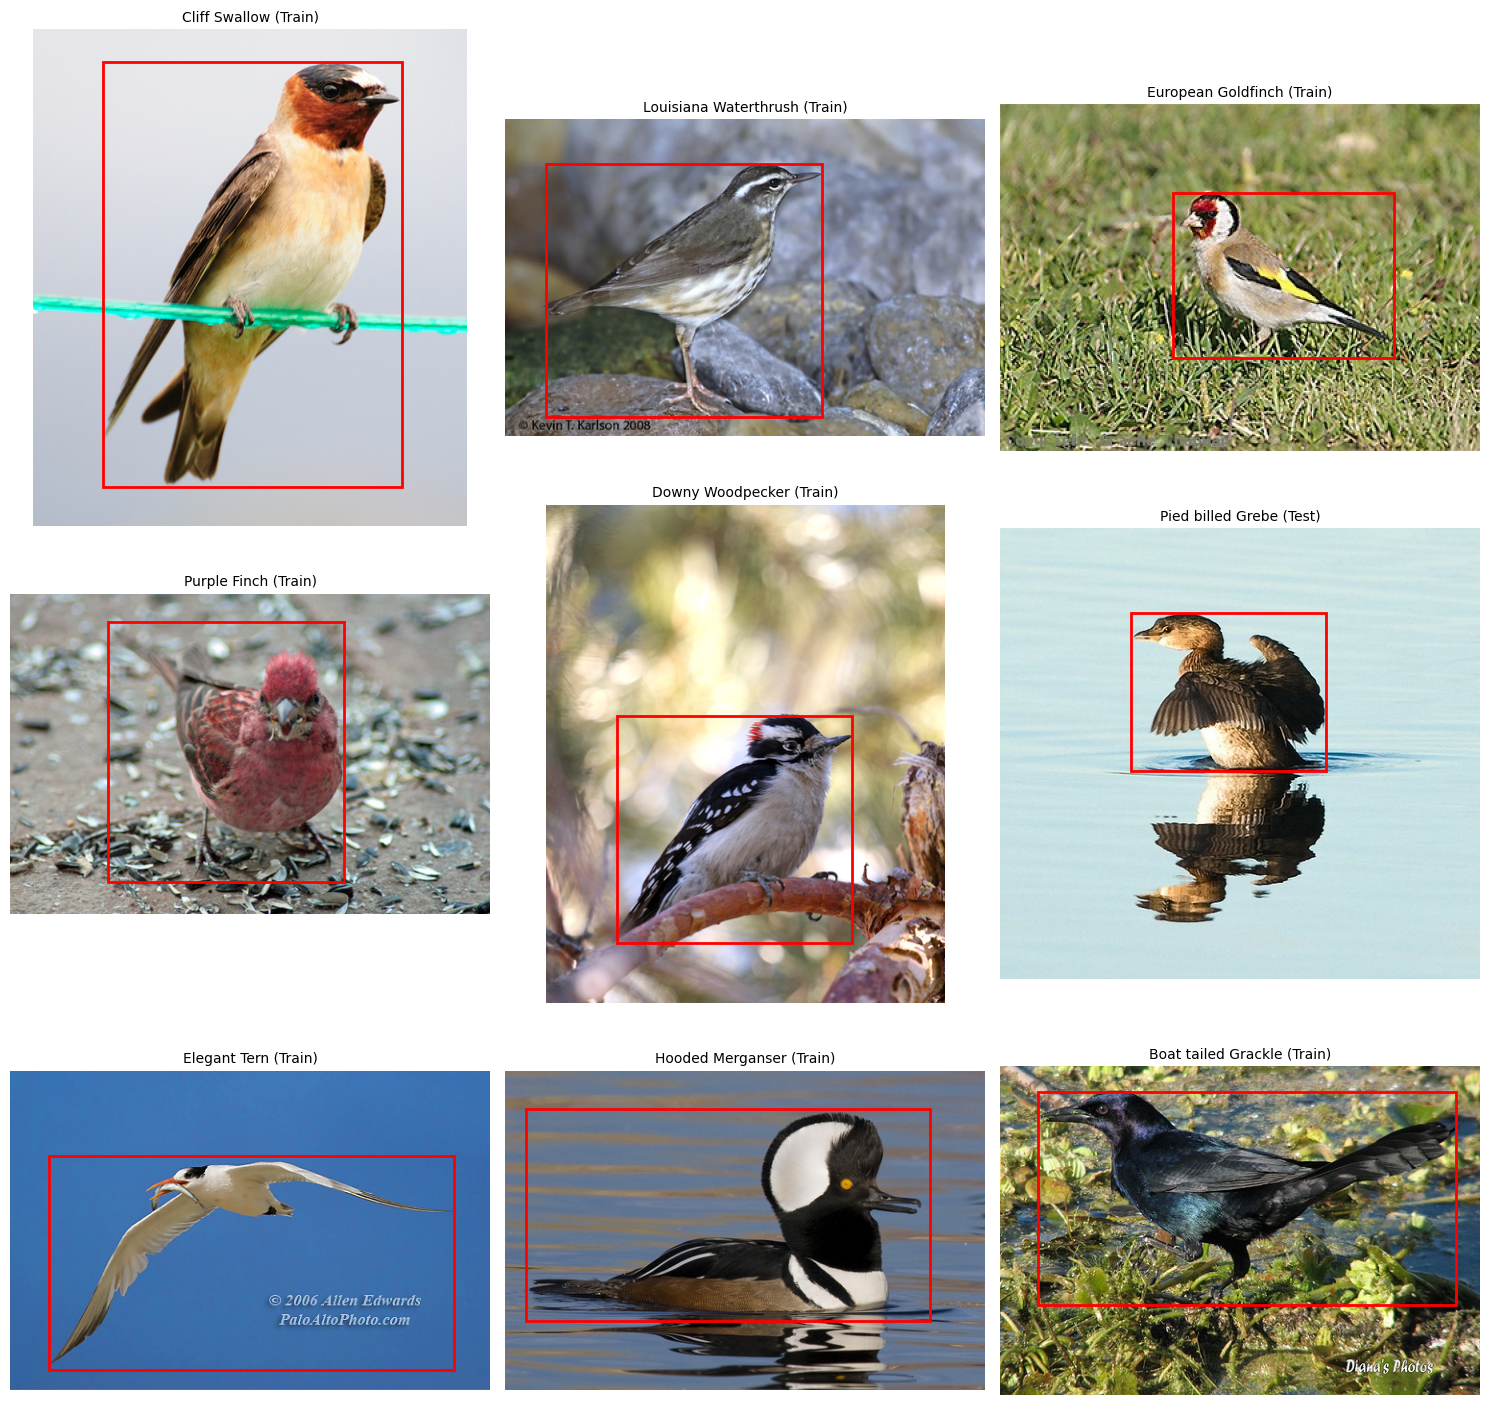

In [ ]:
# Sample 9 random images
sample_df = df.sample(n=9, random_state=42)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, (_, row) in enumerate(sample_df.iterrows()):
    # Load image
    img = Image.open(row['full_path'])

    # Display image
    axes[idx].imshow(img)

    # Draw bounding box
    rect = patches.Rectangle(
        (row['x'], row['y']),
        row['width'],
        row['height'],
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    axes[idx].add_patch(rect)

    # Set title with class info
    split = "Train" if row['is_training'] == 1 else "Test"
    axes[idx].set_title(f"{row['class_name_clean']} ({split})", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 2.2 Train test split

In [ ]:
train_full_df = df[df['is_training'] == 1].reset_index(drop=True)
test_df = df[df['is_training'] == 0].reset_index(drop=True)

train_df, val_df = train_test_split(
    train_full_df,
    test_size=0.1,
    random_state=42,
    stratify=train_full_df['label']
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"\nTrain: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"Train classes: {train_df['label'].nunique()} | Val classes: {val_df['label'].nunique()}")


Train: 5394 | Val: 600 | Test: 5794
Train classes: 200 | Val classes: 200


## 3 Modelling Pipeline Using Pre-trained Model (`EfficientNetB5`) and Weights (`ImageNet`)

### 3.1 Creating Datasets

In [ ]:
IMG_SIZE_b5=456

def create_dataset_with_size(dataframe, img_size, batch_size=32, shuffle=True, padding=0.0):
    def generator():
        for _, row in dataframe.iterrows():
            img = Image.open(row['full_path']).convert('RGB')
            img_w, img_h = img.size

            # Padded bounding box
            pad_w = row['width'] * padding
            pad_h = row['height'] * padding
            x1 = max(0, row['x'] - pad_w)
            y1 = max(0, row['y'] - pad_h)
            x2 = min(img_w, row['x'] + row['width'] + pad_w)
            y2 = min(img_h, row['y'] + row['height'] + pad_h)

            img = img.crop((x1, y1, x2, y2))
            img = img.resize((img_size, img_size), Image.LANCZOS)
            yield np.array(img, dtype=np.float32), row['label']

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=42)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_data_b5 = create_dataset_with_size(train_df, img_size=IMG_SIZE_b5, batch_size=BATCH_SIZE, shuffle=True).repeat()
val_data_b5 = create_dataset_with_size(val_df, img_size=IMG_SIZE_b5, batch_size=BATCH_SIZE, shuffle=False)
test_data_b5 = create_dataset_with_size(test_df, img_size=IMG_SIZE_b5, batch_size=BATCH_SIZE, shuffle=False)

### 3.2 Data Augmentation

Augmentation strategy for transfer learning: horizontal flip (birds appear in both orientations), rotation (±36°), zoom (±15%), translation (±10%), brightness and contrast variation (±20%). These simulate natural variation in wildlife photography without distorting species-discriminative features like plumage colour.

In [ ]:
data_augmentation_cus = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom((-0.15, 0.15)),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
], name='data_augmentation_cus')

### 3.3 Model building and training

#### 3.3.1 Model Architecture

EfficientNetB5 backbone with ImageNet weights is frozen. A custom classification head maps the 2048-dim feature vectors to 200 classes: GAP -> BatchNorm -> Dropout(0.3) -> Dense(512, ReLU) -> Dropout(0.5) -> Dense(200, softmax). The intermediate Dense(512) layer provides a nonlinear projection that helps separate 200 fine-grained classes. Higher dropout (0.5) before the classifier reduces overfitting on ~27 images per class.

In [ ]:
# Phase 1: B5
base_b5 = tf.keras.applications.EfficientNetB5(
    input_shape=(456, 456, 3), include_top=False, weights='imagenet'
)
base_b5.trainable = False

inputs = Input(shape=(456, 456, 3))
x = data_augmentation_cus(inputs)
x = base_b5(x, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model_b5 = tf.keras.Model(inputs, outputs)

model_b5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model_b5.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 456, 456, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_cus           │ (None, 456, 456, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 15, 15, 2048)   │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │       102,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,673,407 (113.20 MB)

 Trainable params: 1,155,784 (4.41 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

#### 3.3.2 Training first phase (freezing back bone model )

In [ ]:
initial_epochs = 20

steps_per_epoch = int(len(train_df)/BATCH_SIZE)

# Train phase 1
history_b5_p1 = model_b5.fit(
    train_data_b5, epochs=initial_epochs, steps_per_epoch=steps_per_epoch,
    validation_data=val_data_b5,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        ModelCheckpoint('b5_phase1.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    ]
)

Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.1179 - loss: 5.3322

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.55500, saving model to b5_phase1.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 1984s 2s/step - accuracy: 0.1184 - loss: 5.3261 - val_accuracy: 0.5550 - val_loss: 2.4347 - learning_rate: 0.0010
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4078 - loss: 2.5913
Epoch 2: val_accuracy improved from 0.55500 to 0.67500, saving model to b5_phase1.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.4080 - loss: 2.5909 - val_accuracy: 0.6750 - val_loss: 1.2238 - learning_rate: 0.0010
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5335 - loss: 1.9467
Epoch 3: val_accuracy improved from 0.67500 to 0.72333, saving model to b5_phase1.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5335 - loss: 1.9469 - val_accuracy: 0.7233 - val_loss: 1.0014 - learning_rate: 0.0010
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.5650 - loss: 1.7625
Epoch 4: val_accuracy improved from 0.72333 to 0.7250

#### Phase 1 learning curve

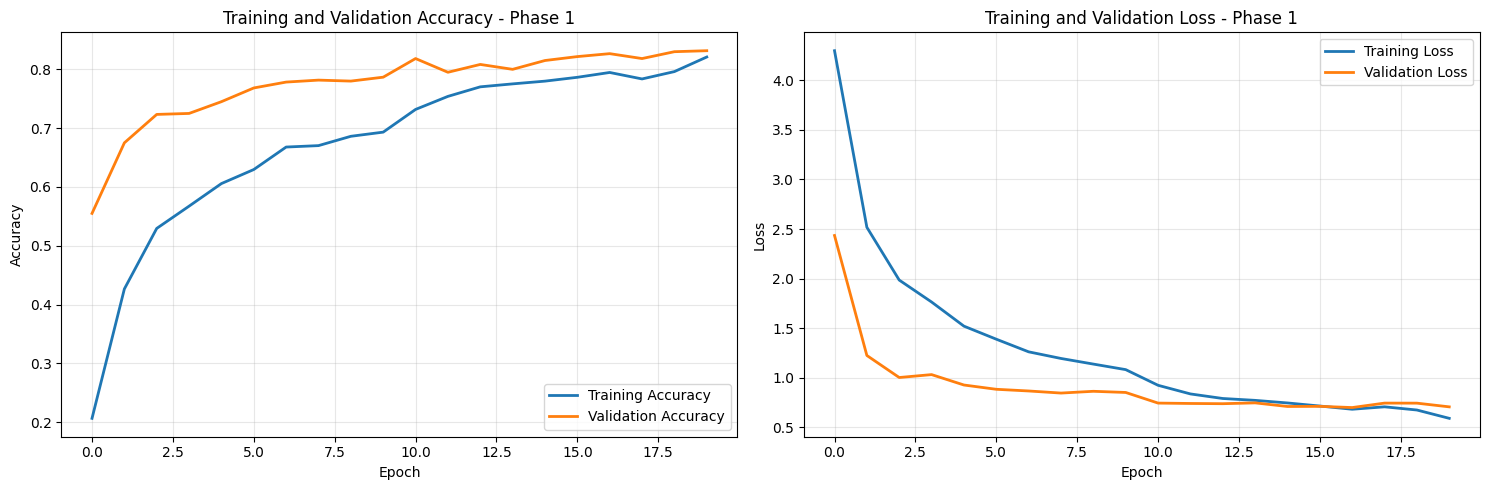

In [ ]:
acc_cus1 = history_b5_p1.history['accuracy']
val_acc_cus1 = history_b5_p1.history['val_accuracy']

loss_cus1 = history_b5_p1.history['loss']
val_loss_cus1= history_b5_p1.history['val_loss']

# Create figure with 2 subplots
plt.figure(figsize=(15, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc_cus1, label='Training Accuracy', linewidth=2)
plt.plot(val_acc_cus1, label='Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - Phase 1')
plt.grid(True, alpha=0.3)

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(loss_cus1, label='Training Loss', linewidth=2)
plt.plot(val_loss_cus1, label='Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Phase 1')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 3.3.3 Unfreezing top blocks of backbone model

In [ ]:
# Phase 2: unfreeze by block, frozen BN
model_b5 = tf.keras.models.load_model('b5_phase1.keras')
print(model_b5.layers)
base_b5 = model_b5.layers[2]

print(f"B5 layers: {len(base_b5.layers)}")
# Print blocks
block_names = sorted(set(
    l.name.split('_')[0] for l in base_b5.layers
))
print(f"Blocks: {block_names} (total: {len(block_names)})")

[<InputLayer name=input_layer_6, built=True>, <Sequential name=data_augmentation_cus, built=True>, <Functional name=efficientnetb5, built=True>, <GlobalAveragePooling2D name=global_average_pooling2d_2, built=True>, <BatchNormalization name=batch_normalization_2, built=True>, <Dropout name=dropout_4, built=True>, <Dense name=dense_4, built=True>, <Dropout name=dropout_5, built=True>, <Dense name=dense_5, built=True>]
B5 layers: 577
Blocks: ['block1a', 'block1b', 'block1c', 'block2a', 'block2b', 'block2c', 'block2d', 'block2e', 'block3a', 'block3b', 'block3c', 'block3d', 'block3e', 'block4a', 'block4b', 'block4c', 'block4d', 'block4e', 'block4f', 'block4g', 'block5a', 'block5b', 'block5c', 'block5d', 'block5e', 'block5f', 'block5g', 'block6a', 'block6b', 'block6c', 'block6d', 'block6e', 'block6f', 'block6g', 'block6h', 'block6i', 'block7a', 'block7b', 'block7c', 'input', 'normalization', 'rescaling', 'stem', 'top'] (total: 44)


Load the best Phase 1 checkpoint and unfreeze blocks 6, 7, and the top convolutional layers while keeping all BatchNormalization layers frozen. BN layers must stay frozen because their running statistics were estimated from millions of ImageNet images

In [ ]:
base_b5.trainable = True

unfreeze_from = ['block6', 'block7', 'top']

for layer in base_b5.layers:
    if any(layer.name.startswith(prefix) for prefix in unfreeze_from):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False  # Keep BN layers frozen to preserve learned stats
        else:
            layer.trainable = True
    else:
        layer.trainable = False

trainable_count = sum(1 for l in base_b5.layers if l.trainable)
total_base_layers = len(base_b5.layers)
print(f"Trainable layers in base: {trainable_count}/{total_base_layers}  "
      f"({trainable_count/total_base_layers:.1%})")

# Additional useful information:
trainable_params = sum([tf.size(w).numpy() for w in base_b5.trainable_weights])
total_params = sum([tf.size(w).numpy() for w in base_b5.weights])
print(f"Trainable parameters: {trainable_params:,}/{total_params:,} "
      f"({trainable_params/total_params:.1%})")

Trainable layers in base: 143/577  (24.8%)
Trainable parameters: 22,855,768/28,513,527 (80.2%)


#### 3.3.4 Model fine tuning

In [ ]:
phase2_epochs = 20
total_epochs = initial_epochs + phase2_epochs
steps_per_epoch = int(len(train_df) / BATCH_SIZE)
total_steps = steps_per_epoch * phase2_epochs

optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=5e-5,
        decay_steps=total_steps,
        alpha=1e-7
    )
)

model_b5.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'b5_phase2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
]

history_phase2 = model_b5.fit(
    train_data_b5,
    epochs=total_epochs,
    initial_epoch=len(history_b5_p1.epoch),
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_b5,
    callbacks=callbacks,
    verbose=1
)

Epoch 21/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.8384 - loss: 0.5129

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 21: val_accuracy improved from -inf to 0.83333, saving model to b5_phase2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.8385 - loss: 0.5128 - val_accuracy: 0.8333 - val_loss: 0.7072
Epoch 22/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8656 - loss: 0.4561
Epoch 22: val_accuracy improved from 0.83333 to 0.84500, saving model to b5_phase2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.8656 - loss: 0.4559 - val_accuracy: 0.8450 - val_loss: 0.6674
Epoch 23/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8790 - loss: 0.3830
Epoch 23: val_accuracy improved from 0.84500 to 0.85333, saving model to b5_phase2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.8790 - loss: 0.3830 - val_accuracy: 0.8533 - val_loss: 0.6653
Epoch 24/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8964 - loss: 0.3246
Epoch 24: val_accuracy improved from 0.85333 to 0.85833, saving model to b5_phase2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 206s 

#### Phase 2 learning curve

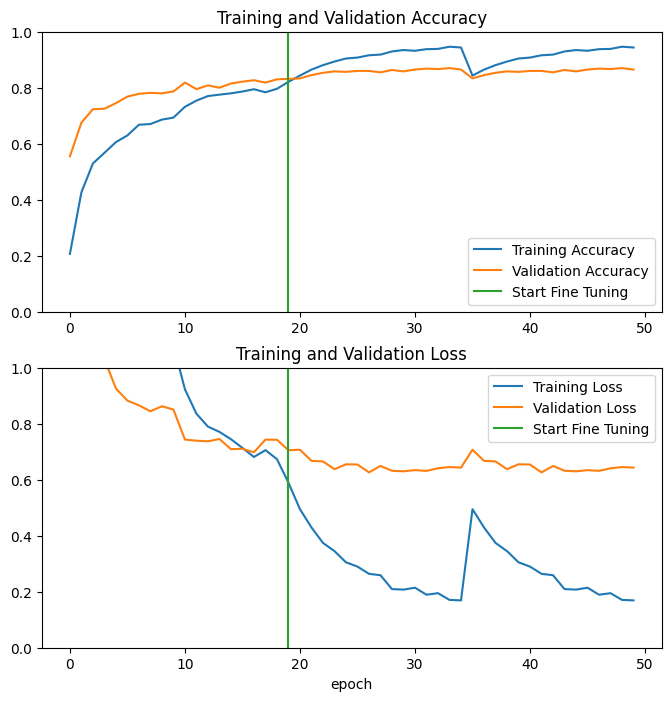

In [ ]:
acc_cus1 += history_phase2.history['accuracy']
val_acc_cus1 += history_phase2.history['val_accuracy']

loss_cus1 += history_phase2.history['loss']
val_loss_cus1 += history_phase2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_cus1, label='Training Accuracy')
plt.plot(val_acc_cus1, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_cus1, label='Training Loss')
plt.plot(val_loss_cus1, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model for later use

In [ ]:
# Define save path in Google Drive
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/'

# Create directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# Save the best model from Phase 2
# shutil.copy('best_phase2.keras',
#             os.path.join(model_save_path, 'best_phase2.keras'))

# shutil.copy('b5_phase1.keras',
#             os.path.join(model_save_path, 'b5_phase1.keras'))

In [6]:
# Load the saved model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/'
model_final = tf.keras.models.load_model(
    os.path.join(model_save_path, 'b5_phase2.keras')
)

print("Model loaded successfully from Google Drive!")

# Verify it works
model_final.summary()

Model loaded successfully from Google Drive!


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 456, 456, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_cus           │ (None, 456, 456, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 15, 15, 2048)   │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │       102,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,684,960 (204.79 MB)

 Trainable params: 24,011,552 (91.60 MB)

 Non-trainable params: 5,661,855 (21.60 MB)

 Optimizer params: 24,011,553 (91.60 MB)

### 3.4 Model evaluation

#### 3.4.1 Testing with Test time augmentation

At inference, each test image is evaluated under 4 transforms and predictions are averaged. TTA provides a small accuracy boost by reducing sensitivity to specific image orientations.

In [ ]:
# model_final = tf.keras.models.load_model('b5_phase2.keras')

# TTA Prediction
def predict_with_tta(model, dataset, img_size=456):
    all_preds = []
    all_labels = np.concatenate([lbl.numpy() for _, lbl in dataset])

    def hflip(img, lbl):
        return tf.image.flip_left_right(img), lbl

    def crop90(img, lbl):
        crop = int(img_size * 0.9)
        img = tf.image.resize_with_crop_or_pad(img, crop, crop)
        img = tf.image.resize(img, [img_size, img_size])
        return img, lbl

    def hflip_crop90(img, lbl):
        img = tf.image.flip_left_right(img)
        crop = int(img_size * 0.9)
        img = tf.image.resize_with_crop_or_pad(img, crop, crop)
        img = tf.image.resize(img, [img_size, img_size])
        return img, lbl

    transforms = [
        ("Standard", None),
        ("HFlip", hflip),
        ("Crop90", crop90),
        ("HFlip+Crop90", hflip_crop90),
    ]

    for name, transform in transforms:
        ds = dataset.map(transform) if transform else dataset
        preds = model.predict(ds, verbose=0)
        all_preds.append(preds)
        acc = np.mean(np.argmax(preds, axis=1) == all_labels)
        print(f"  {name}: {acc:.4f}")

    avg_preds = np.mean(all_preds, axis=0)
    predicted = np.argmax(avg_preds, axis=1)
    accuracy = np.mean(predicted == all_labels)
    print(f"\n  TTA Combined: {accuracy:.4f}")

    return predicted, all_labels

print("Running TTA on test set...")
y_pred, y_true = predict_with_tta(model_final, test_data_b5)

Running TTA on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


  Standard: 0.8609
  HFlip: 0.8592
  Crop90: 0.8592
  HFlip+Crop90: 0.8593

  TTA Combined: 0.8619


#### 3.4.2 Classification report

In [ ]:
# Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1-Score (macro and weighted averages)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

# Per-class metrics
precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

In [ ]:
# classes_df = pd.read_csv(
#     os.path.join(base_dir, 'classes.txt'),
#     sep=' ', header=None, names=['class_id', 'class_name']
# )
# Convert to 0-indexed to match your labels (0-199)
class_names = classes_df['class_name'].tolist()

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,  # Real bird names now!
    zero_division=0,
    digits=4
)
print("\n" + "="*70)
print("CLASSIFICATION REPORT WITH BIRD NAMES")
print("="*70)
print(report)


CLASSIFICATION REPORT WITH BIRD NAMES
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross     0.9286    0.8667    0.8966        30
              002.Laysan_Albatross     0.8750    0.9333    0.9032        30
               003.Sooty_Albatross     0.7941    0.9643    0.8710        28
             004.Groove_billed_Ani     1.0000    0.9000    0.9474        30
                005.Crested_Auklet     1.0000    1.0000    1.0000        14
                  006.Least_Auklet     0.9000    0.8182    0.8571        11
               007.Parakeet_Auklet     0.9583    1.0000    0.9787        23
             008.Rhinoceros_Auklet     0.8095    0.9444    0.8718        18
              009.Brewer_Blackbird     0.5667    0.5862    0.5763        29
          010.Red_winged_Blackbird     1.0000    1.0000    1.0000        30
               011.Rusty_Blackbird     0.7200    0.6000    0.6545        30
       012.Yellow_headed_Blackbird     0.9630   

#### 3.4.3 Confusion matrix

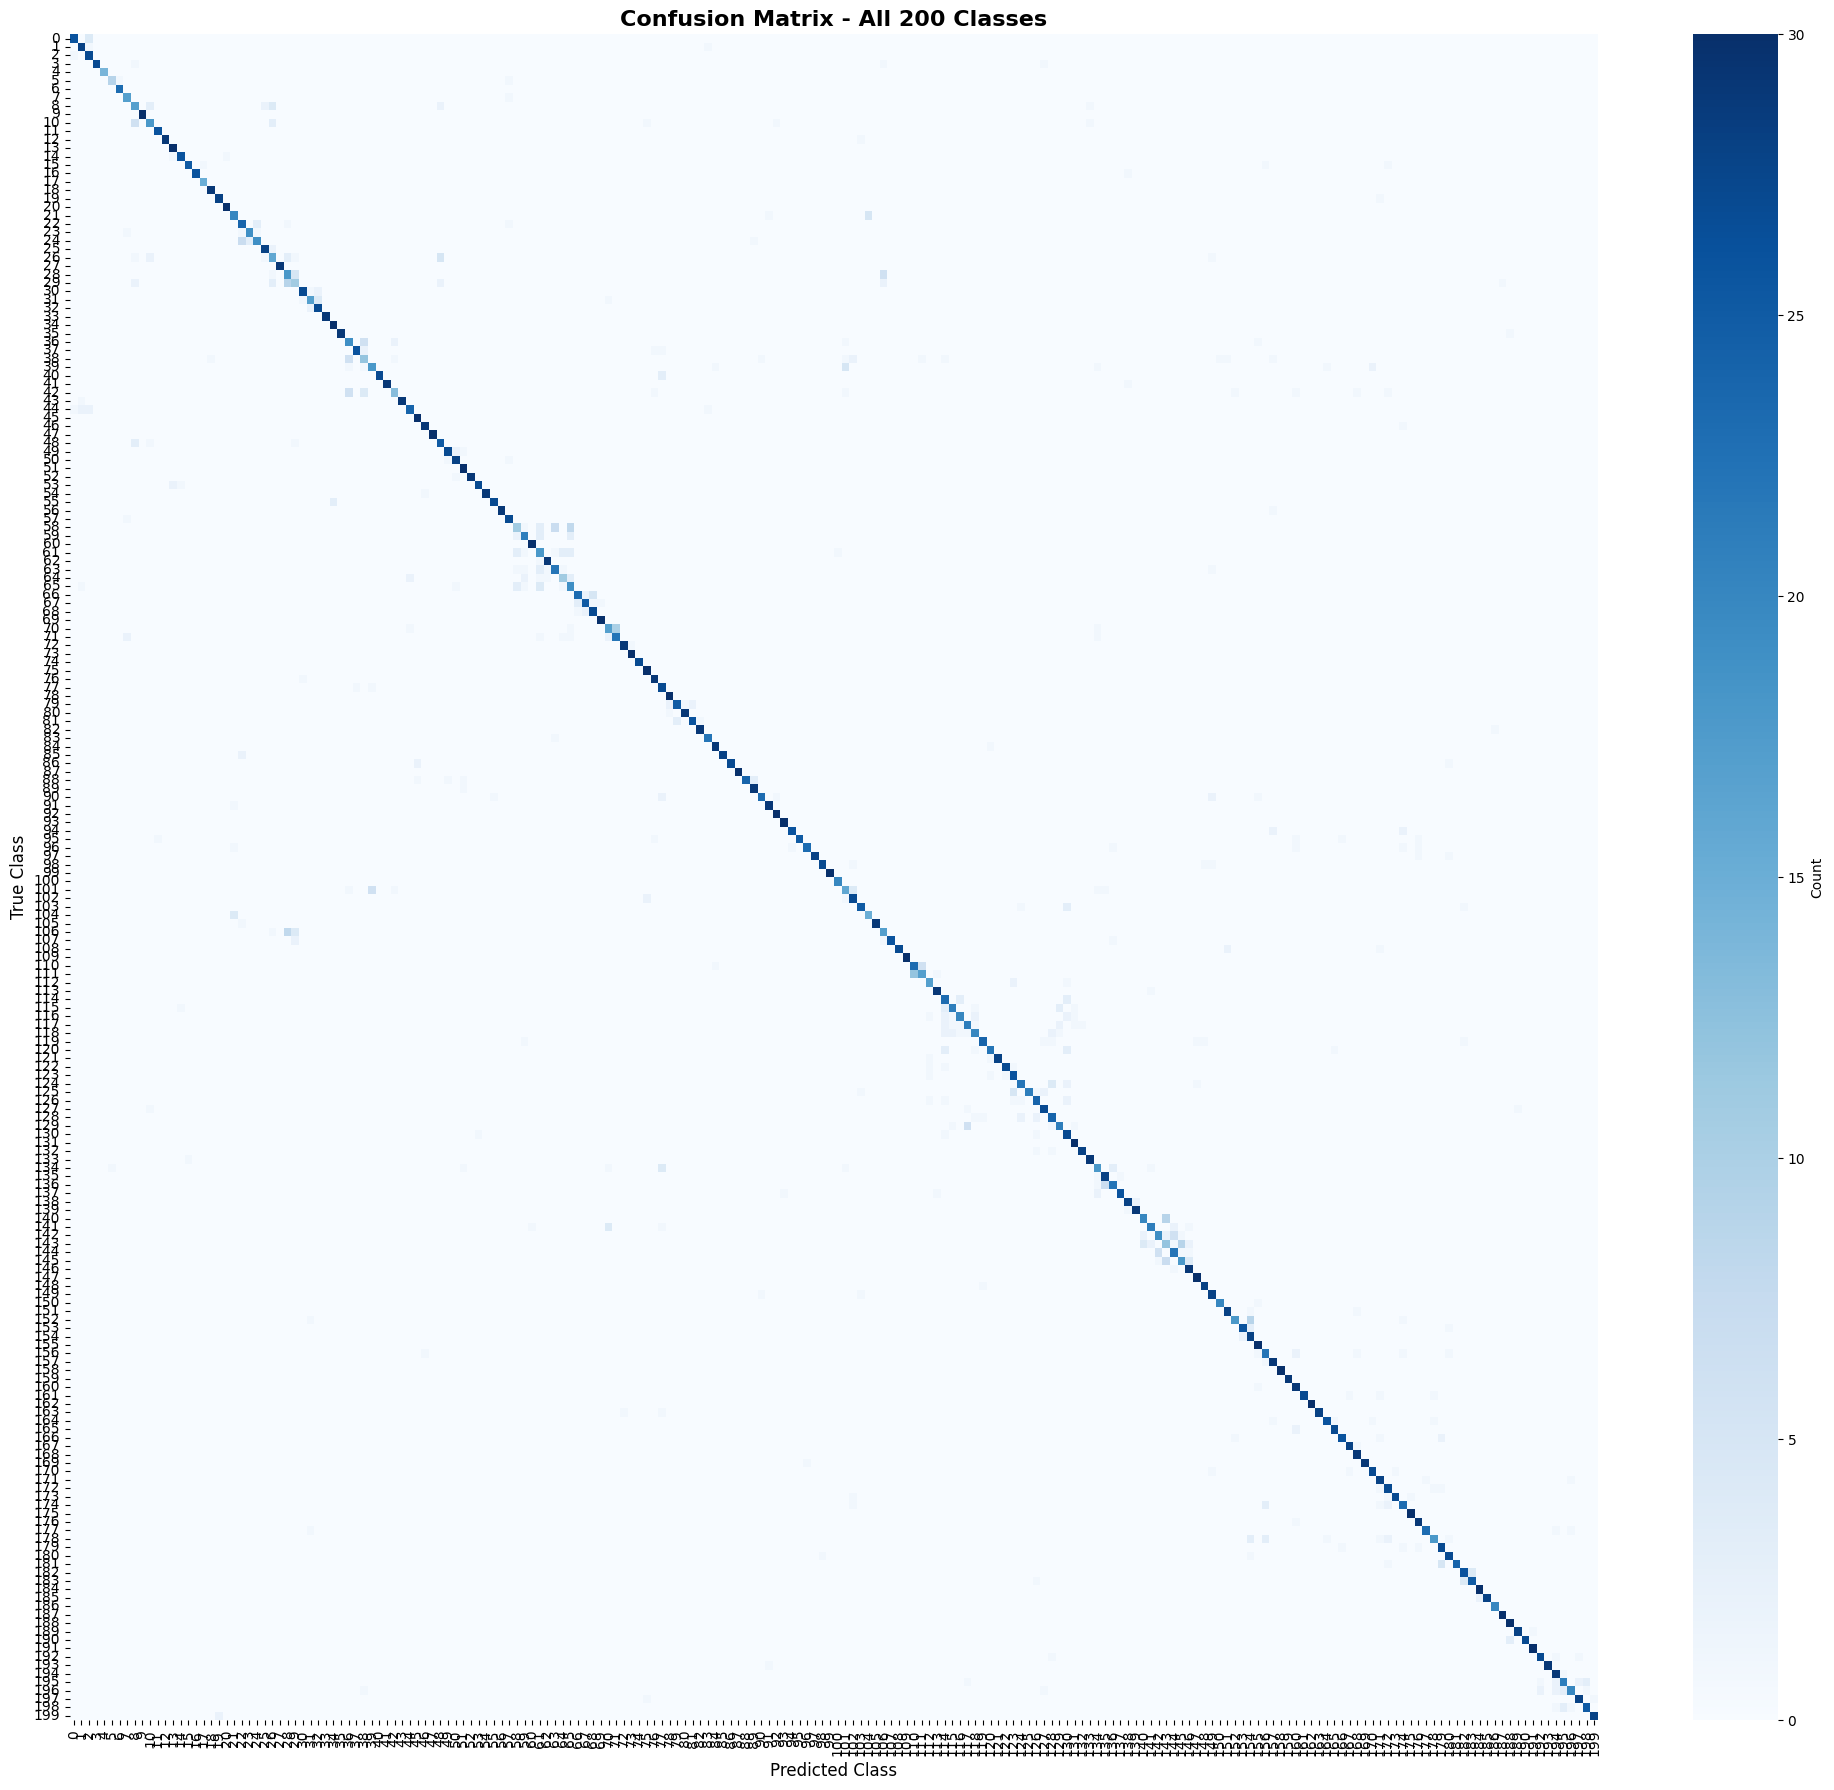

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Full confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=range(200), yticklabels=range(200),
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - All 200 Classes', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()

#### 3.4.4 Per class accuracy distributions

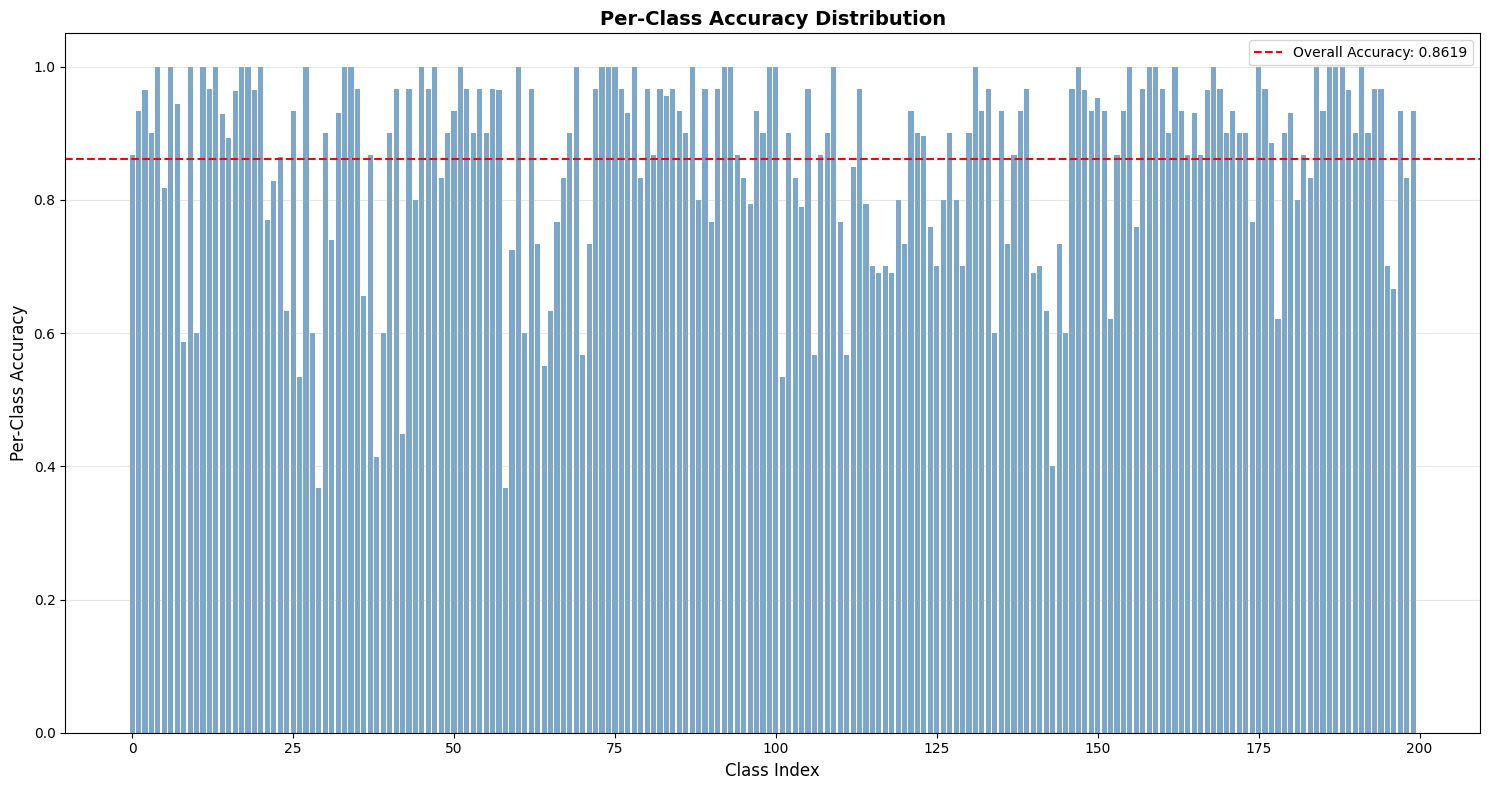

In [ ]:
plt.figure(figsize=(15, 8))
diagonal_accuracy = np.diag(cm) / cm.sum(axis=1)
plt.bar(range(200), diagonal_accuracy, color='steelblue', alpha=0.7)
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Overall Accuracy: {accuracy:.4f}')
plt.xlabel('Class Index', fontsize=12)
plt.ylabel('Per-Class Accuracy', fontsize=12)
plt.title('Per-Class Accuracy Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

#### 3.4.5 Top and bottom classes by accuracy

In [ ]:
# Sort by per-class accuracy
print("TOP 10 BEST PERFORMING CLASSES")

class_accuracy = np.diag(cm) / cm.sum(axis=1)
top_10_indices = np.argsort(class_accuracy)[-10:][::-1]

for rank, idx in enumerate(top_10_indices, 1):
    print(f"{rank:2d}. Class {idx:3d}: {class_accuracy[idx]:.4f} "
          f"({int(np.diag(cm)[idx])}/{int(cm.sum(axis=1)[idx])} correct)")

print("TOP 10 WORST PERFORMING CLASSES")

bottom_10_indices = np.argsort(class_accuracy)[:10]

for rank, idx in enumerate(bottom_10_indices, 1):
    print(f"{rank:2d}. Class {idx:3d}: {class_accuracy[idx]:.4f} "
          f"({int(np.diag(cm)[idx])}/{int(cm.sum(axis=1)[idx])} correct)")

TOP 10 BEST PERFORMING CLASSES
 1. Class 175: 1.0000 (30/30 correct)
 2. Class 168: 1.0000 (29/29 correct)
 3. Class 162: 1.0000 (30/30 correct)
 4. Class 184: 1.0000 (30/30 correct)
 5. Class 187: 1.0000 (30/30 correct)
 6. Class 186: 1.0000 (20/20 correct)
 7. Class 188: 1.0000 (30/30 correct)
 8. Class 191: 1.0000 (30/30 correct)
 9. Class 147: 1.0000 (30/30 correct)
10. Class 155: 1.0000 (30/30 correct)
TOP 10 WORST PERFORMING CLASSES
 1. Class  29: 0.3667 (11/30 correct)
 2. Class  58: 0.3667 (11/30 correct)
 3. Class 143: 0.4000 (12/30 correct)
 4. Class  38: 0.4138 (12/29 correct)
 5. Class  42: 0.4483 (13/29 correct)
 6. Class  26: 0.5333 (16/30 correct)
 7. Class 101: 0.5333 (16/30 correct)
 8. Class  64: 0.5500 (11/20 correct)
 9. Class  70: 0.5667 (17/30 correct)
10. Class 111: 0.5667 (17/30 correct)


#### 3.4.6 Per class Accuracy, Precision, Recall, F1-score

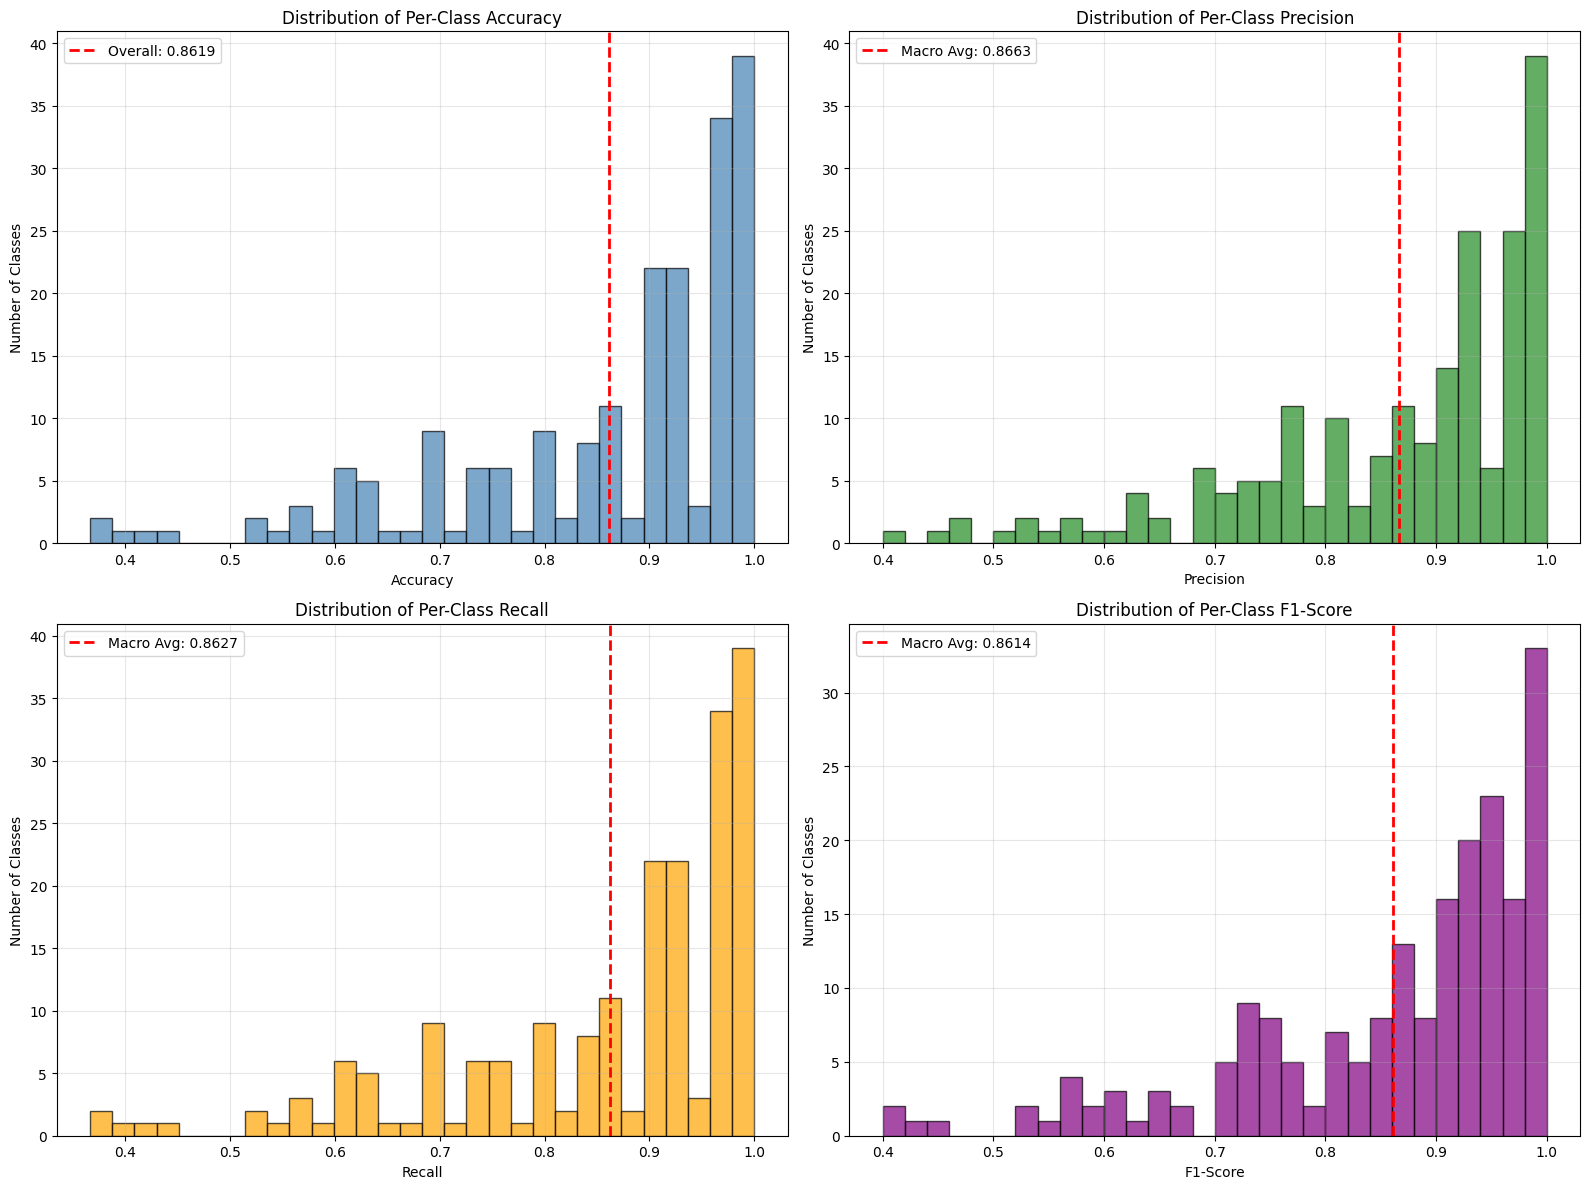

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy distribution
axes[0, 0].hist(class_accuracy, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(accuracy, color='red', linestyle='--', linewidth=2,
                   label=f'Overall: {accuracy:.4f}')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Number of Classes')
axes[0, 0].set_title('Distribution of Per-Class Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Precision distribution
axes[0, 1].hist(precision_per_class, bins=30, color='forestgreen', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(precision_macro, color='red', linestyle='--', linewidth=2,
                   label=f'Macro Avg: {precision_macro:.4f}')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_ylabel('Number of Classes')
axes[0, 1].set_title('Distribution of Per-Class Precision')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Recall distribution
axes[1, 0].hist(recall_per_class, bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(recall_macro, color='red', linestyle='--', linewidth=2,
                   label=f'Macro Avg: {recall_macro:.4f}')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Number of Classes')
axes[1, 0].set_title('Distribution of Per-Class Recall')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: F1-Score distribution
axes[1, 1].hist(f1_per_class, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(f1_macro, color='red', linestyle='--', linewidth=2,
                   label=f'Macro Avg: {f1_macro:.4f}')
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_ylabel('Number of Classes')
axes[1, 1].set_title('Distribution of Per-Class F1-Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4 Task 2: Building custom model

### 4.1 Custom setup

In [ ]:
IMG_SIZE_cus = 224
def create_dataset(dataframe, img_size, batch_size=32, shuffle=True):
    """Load images with bounding box crops. No pretrained preprocessing."""
    def generator():
        for _, row in dataframe.iterrows():
            img = Image.open(row['full_path']).convert('RGB')
            img_w, img_h = img.size

            # Crop to bounding box
            x1 = max(0, row['x'])
            y1 = max(0, row['y'])
            x2 = min(img_w, row['x'] + row['width'])
            y2 = min(img_h, row['y'] + row['height'])
            img = img.crop((x1, y1, x2, y2))
            img = img.resize((img_size, img_size), Image.LANCZOS)

            img_array = np.array(img, dtype=np.float32)
            yield img_array, row['label']

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=42)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_data_cus = create_dataset(train_df, img_size=IMG_SIZE_cus, batch_size=BATCH_SIZE, shuffle=True).repeat()
val_data_cus = create_dataset(val_df, img_size=IMG_SIZE_cus, batch_size=BATCH_SIZE, shuffle=False)
test_data_cus = create_dataset(test_df, img_size=IMG_SIZE_cus, batch_size=BATCH_SIZE, shuffle=False)

### 4.2 Squeeze-and-Excitation: channel attention mechanism

Channel attention mechanism that learns to weight feature channels by importance. For bird classification, this helps the network emphasise colour channels for colourful species and texture channels for camouflaged species. The squeeze step (GAP) captures channel-wise statistics, and two Dense layers learn the recalibration weights.

In [ ]:
def squeeze_excite_block(x, ratio=16):
    """
    Squeeze-and-Excitation: channel attention mechanism.

    GAP squeezes spatial dims -> two Dense layers learn channel importance
    -> sigmoid gates each channel.
    """
    filters = x.shape[-1]
    se = tf.keras.layers.GlobalAveragePooling2D()(x)
    se = Dense(filters // ratio, activation='relu',
               kernel_initializer='he_normal')(se)
    se = Dense(filters, activation='sigmoid',
               kernel_initializer='he_normal')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([x, se])

### 4.3 Residual block with optional Squeeze-and-Excitation

Pre-activation residual block (BN -> ReLU -> Conv) with optional SE attention. Skip connections allow gradients to flow directly through the shortcut path during backpropagation, enabling training of a 20+ layer network from scratch on only ~5,400 images. The 1×1 convolution shortcut matches dimensions when filter count or spatial size changes.

In [ ]:
def residual_block(x, filters, strides=1, use_se=True):
    """
    Residual block with optional Squeeze-and-Excitation.

    Architecture: BN -> ReLU -> Conv -> BN -> ReLU -> Conv -> SE -> Add(shortcut)
    Uses "pre-activation" style (BN/ReLU before conv) which is empirically
    better for training from scratch (He et al., 2016).
    """
    shortcut = x

    # Pre-activation
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # First conv — may downsample spatially
    x = Conv2D(filters, 3, strides=strides, padding='same',
               kernel_initializer='he_normal', use_bias=False)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second conv
    x = Conv2D(filters, 3, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=False)(x)

    # Squeeze-and-Excitation
    if use_se:
        x = squeeze_excite_block(x)

    # Shortcut: match dimensions if filter count or spatial size changed
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=strides, padding='same',
                          kernel_initializer='he_normal', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    return x

### 4.4 Depthwise separable convolution block

Factorises a standard convolution into depthwise (spatial filtering per channel) and pointwise (channel mixing) operations, reducing parameters by ~8-9x. Used in Stage 4 where the 512 channel count would make standard convolutions prohibitively expensive for a from-scratch model on limited data.

For a from-scratch model on small data, this parameter efficiency means we can have wider/deeper networks without proportionally more overfitting.

In [ ]:
def depthwise_separable_block(x, filters, strides=1):
    """ Depthwise separable convolution block """
    # Depthwise: spatial filtering
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = DepthwiseConv2D(3, strides=strides, padding='same',
                        depthwise_initializer='he_normal', use_bias=False)(x)

    # Pointwise: channel mixing
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 1, padding='same',
               kernel_initializer='he_normal', use_bias=False)(x)

    return x

### 4.5 Building custom model architecture

**Stage layout:**
- Stem:   7×7 conv, stride 2 -> 3×3 maxpool -> output: 56×56×64
- Stage1: 2 residual blocks, 64 filters  -> 56×56×64
- Stage2: 2 residual blocks, 128 filters -> 28×28×128
- Stage3: 2 residual blocks, 256 filters -> 14×14×256
- Stage4: 1 residual + 1 depthwise sep, 512 filters -> 7×7×512
- Head:   GAP -> Dropout -> Dense(512) -> Dropout -> Dense(200)

In [ ]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=200):
    """Custom CNN architecture for fine-grained classification from scratch"""
    inputs = Input(shape=input_shape)

    x = data_augmentation_cus(inputs)
    x = tf.keras.layers.Rescaling(1./255)(x)

    # Stem: aggressive spatial reduction
    # 7x7 conv with stride 2 quickly reduces 224->112, capturing broad features
    # MaxPool further reduces to 56x56 — standard ResNet stem design
    x = Conv2D(64, 7, strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Stage 1: Low-level features (edges, simple textures)
    # 56x56x64 — no spatial reduction, 2 residual blocks
    x = residual_block(x, 64, strides=1)
    x = residual_block(x, 64, strides=1)

    # Stage 2: Mid-level features (complex textures, local patterns)
    # 56x56->28x28, channels 64->128
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128, strides=1)

    # Stage 3: High-level features (bird parts — beak, wing, breast)
    # 28x28->14x14, channels 128->256
    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256, strides=1)

    # Stage 4: Semantic features (species-level discrimination)
    # 14x14->7x7, channels 256->512
    # Mix of residual + depthwise separable for parameter efficiency
    x = residual_block(x, 512, strides=2)
    x = depthwise_separable_block(x, 512, strides=1)

    # Final SE block on the full feature map
    x = squeeze_excite_block(x)

    # Classification head
    # GAP: 7x7x512 -> 512-dim vector
    # Why GAP over Flatten: Flatten would give 7x7x512 = 25,088 dims,
    # meaning the Dense(200) layer alone would have 5M params.
    # GAP gives 512 dims -> Dense(512)-> Dense(200)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax',
                    kernel_initializer='he_normal')(x)

    model = tf.keras.Model(inputs, outputs, name='Custom_CNN_Model')
    return model

### 4.6 Preparing data and parameters for training

In [ ]:
data_augmentation_cus = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom((-0.15, 0.15)),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomBrightness(0.2),
    # tf.keras.layers.RandomContrast(0.2),
    # tf.keras.layers.RandomSaturation(0.3),
    # tf.keras.layers.RandomHue(0.1),
], name='data_augmentation')

In [ ]:
model = build_custom_cnn(input_shape=(IMG_SIZE_cus, IMG_SIZE_cus, 3), num_classes=NUM_CLASSES)
model.summary()

# Print parameter breakdown by stage
print("\nParameter Breakdown")
total_params = model.count_params()
print(f"Total parameters: {total_params:,}")
print(f"Parameters per training sample: {total_params / len(train_df):.0f}")

Model: "Custom_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_21[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_247 (Conv2D) │ (None, 112, 112,  │      9,408 │ rescaling_3[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_247[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_234      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 56, 56,    │          0 │ activation_234[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d_13… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_235      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_248 (Conv2D) │ (None, 56, 56,    │     36,864 │ activation_235[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_248[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_236      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_249 (Conv2D) │ (None, 56, 56,    │     36,864 │ activation_236[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_249[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_230 (Dense)   │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_231 (Dense)   │ (None, 64)        │        320 │ dense_230[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_104         │ (None, 1, 1, 64)  │          0 │ dense_231[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,188,864 (27.42 MB)

 Trainable params: 7,179,136 (27.39 MB)

 Non-trainable params: 9,728 (38.00 KB)


Parameter Breakdown
Total parameters: 7,188,864
Parameters per training sample: 1333


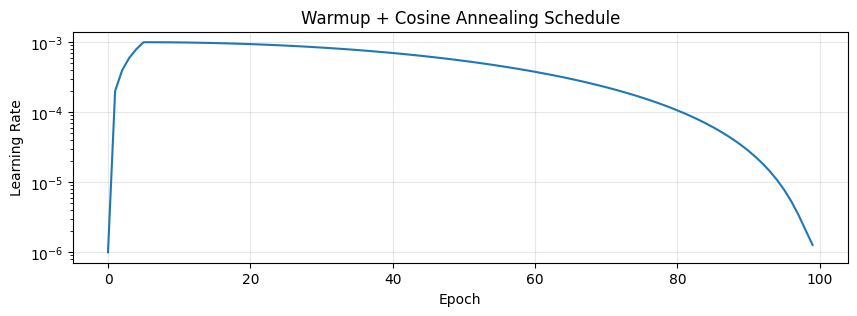

In [ ]:
EPOCHS = 100
WARMUP_EPOCHS = 5
INITIAL_LR = 1e-3
MIN_LR = 1e-6

steps_per_epoch = len(train_df) // BATCH_SIZE

def lr_schedule(epoch):
    """Warmup + cosine annealing."""
    if epoch < WARMUP_EPOCHS:
        # Linear warmup
        return MIN_LR + (INITIAL_LR - MIN_LR) * (epoch / WARMUP_EPOCHS)
    else:
        # Cosine decay
        progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
        return MIN_LR + 0.5 * (INITIAL_LR - MIN_LR) * (1 + np.cos(np.pi * progress))


# Visualize schedule
lr_values = [lr_schedule(e) for e in range(EPOCHS)]
plt.figure(figsize=(10, 3))
plt.plot(lr_values)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Warmup + Cosine Annealing Schedule')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

### 4.7 Model training

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=INITIAL_LR,
        weight_decay=1e-4
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks = [
    LearningRateScheduler(lr_schedule, verbose=1),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'custom_model_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
]

history = model.fit(
    train_data_cus,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_cus,
    callbacks=callbacks,
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0032 - loss: 5.5643
Epoch 1: val_accuracy improved from -inf to 0.00500, saving model to custom_model_best.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 73s 129ms/step - accuracy: 0.0032 - loss: 5.5643 - val_accuracy: 0.0050 - val_loss: 5.3178 - learning_rate: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.00020080000000000003.
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.0070 - loss: 5.4402
Epoch 2: val_accuracy improved from 0.00500 to 0.00833, saving model to custom_model_best.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 56s 335ms/step - accuracy: 0.0070 - loss: 5.4398 - val_accuracy: 0.0083 - val_loss: 5.2865 - learning_rate: 2.0080e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0004006000000000001.
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.0122 - loss: 5.2516
Epoch 3: val_accuracy im

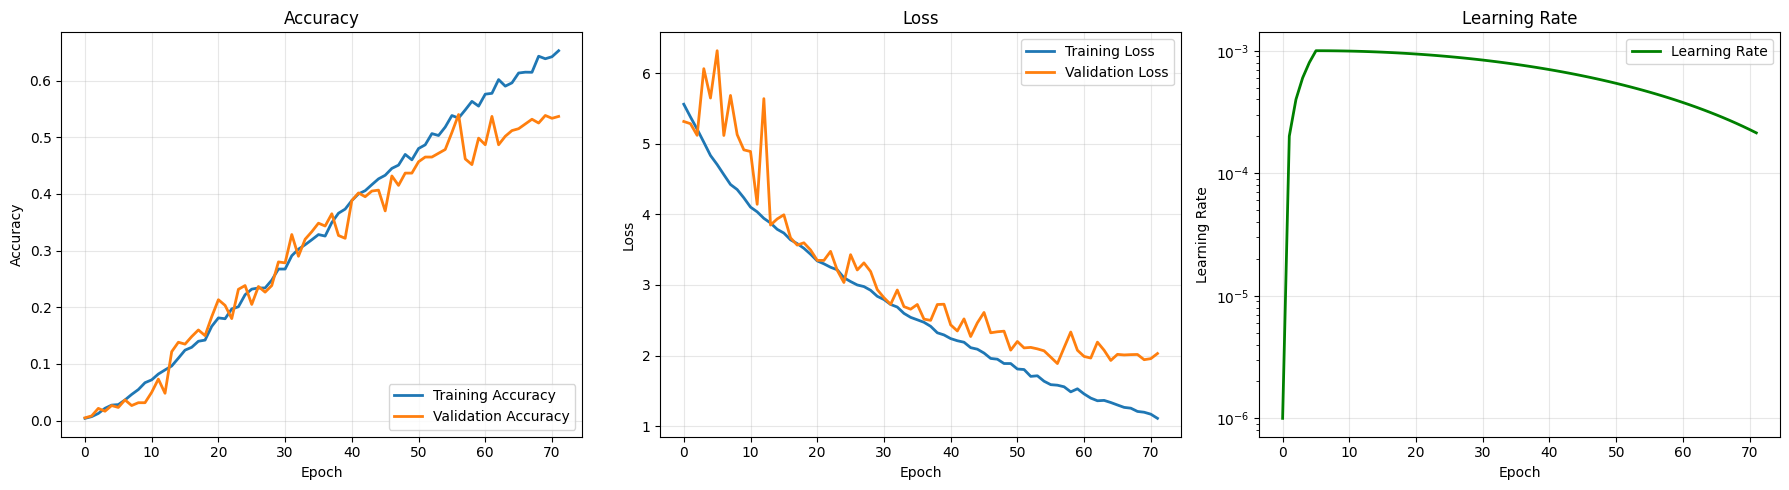

In [ ]:
# Retrieve metrics from history
acc_cus = history.history['accuracy']
val_acc_cus = history.history['val_accuracy']
loss_cus = history.history['loss']
val_loss_cus = history.history['val_loss']

# Fetch learning rate

lr_cus = history.history.get('learning_rate')

# Create figure with 3 subplots
plt.figure(figsize=(18, 5))

# Plot 1: Accuracy
plt.subplot(1, 3, 1)
plt.plot(acc_cus, label='Training Accuracy', linewidth=2)
plt.plot(val_acc_cus, label='Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True, alpha=0.3)

# Plot 2: Loss
plt.subplot(1, 3, 2)
plt.plot(loss_cus, label='Training Loss', linewidth=2)
plt.plot(val_loss_cus, label='Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True, alpha=0.3)

# Plot 3: Learning Rate
plt.subplot(1, 3, 3)
plt.plot(lr_cus, label='Learning Rate', linewidth=2, color='green')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Save model for later use

In [ ]:
# Define save path in Google Drive
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/'

# Create directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# Save the best model
shutil.copy('custom_model_best.keras',
            os.path.join(model_save_path, 'custom_model_best.keras'))

'/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/custom_model_best.keras'

In [ ]:
# Load the saved model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/'
model_final = tf.keras.models.load_model(
    os.path.join(model_save_path, 'custom_model_best.keras')
)

print("Model loaded successfully from Google Drive!")

# Verify it works
model_final.summary()

Model loaded successfully from Google Drive!


Model: "Custom_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_21[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_247 (Conv2D) │ (None, 112, 112,  │      9,408 │ rescaling_3[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_247[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_234      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 56, 56,    │          0 │ activation_234[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d_13… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_235      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_248 (Conv2D) │ (None, 56, 56,    │     36,864 │ activation_235[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_248[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_236      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_249 (Conv2D) │ (None, 56, 56,    │     36,864 │ activation_236[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_249[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_230 (Dense)   │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_231 (Dense)   │ (None, 64)        │        320 │ dense_230[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_104         │ (None, 1, 1, 64)  │          0 │ dense_231[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,547,138 (82.20 MB)

 Trainable params: 7,179,136 (27.39 MB)

 Non-trainable params: 9,728 (38.00 KB)

 Optimizer params: 14,358,274 (54.77 MB)

### 4.8 Model evaluation

#### 4.8.1 Tesing on test set

In [ ]:
y_true = []
y_pred = []

for images, labels in test_data_cus:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_acc = np.mean(y_true == y_pred)
print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Random Baseline: {1/NUM_CLASSES:.4f} ({100/NUM_CLASSES:.2f}%)")
print(f"Improvement over random: {test_acc / (1/NUM_CLASSES):.1f}x")


Test Accuracy: 0.5009 (50.09%)
Random Baseline: 0.0050 (0.50%)
Improvement over random: 100.2x


#### 4.8.2 Classification report

In [ ]:
# Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1-Score (macro and weighted averages)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

# Per-class metrics
precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

In [ ]:
class_names = classes_df['class_name'].tolist()

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    zero_division=0,
    digits=4
)
print("\n" + "="*70)
print("CLASSIFICATION REPORT WITH BIRD NAMES")
print("="*70)
print(report)


CLASSIFICATION REPORT WITH BIRD NAMES
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross     0.3947    0.5000    0.4412        30
              002.Laysan_Albatross     0.4167    0.1667    0.2381        30
               003.Sooty_Albatross     0.2105    0.1429    0.1702        28
             004.Groove_billed_Ani     0.3333    0.1667    0.2222        30
                005.Crested_Auklet     0.3158    0.4286    0.3636        14
                  006.Least_Auklet     0.3913    0.8182    0.5294        11
               007.Parakeet_Auklet     0.6667    0.7826    0.7200        23
             008.Rhinoceros_Auklet     0.3750    0.5000    0.4286        18
              009.Brewer_Blackbird     0.0000    0.0000    0.0000        29
          010.Red_winged_Blackbird     0.9231    0.8000    0.8571        30
               011.Rusty_Blackbird     0.4118    0.2333    0.2979        30
       012.Yellow_headed_Blackbird     0.8800   

#### 4.8.3 Confusion matrix

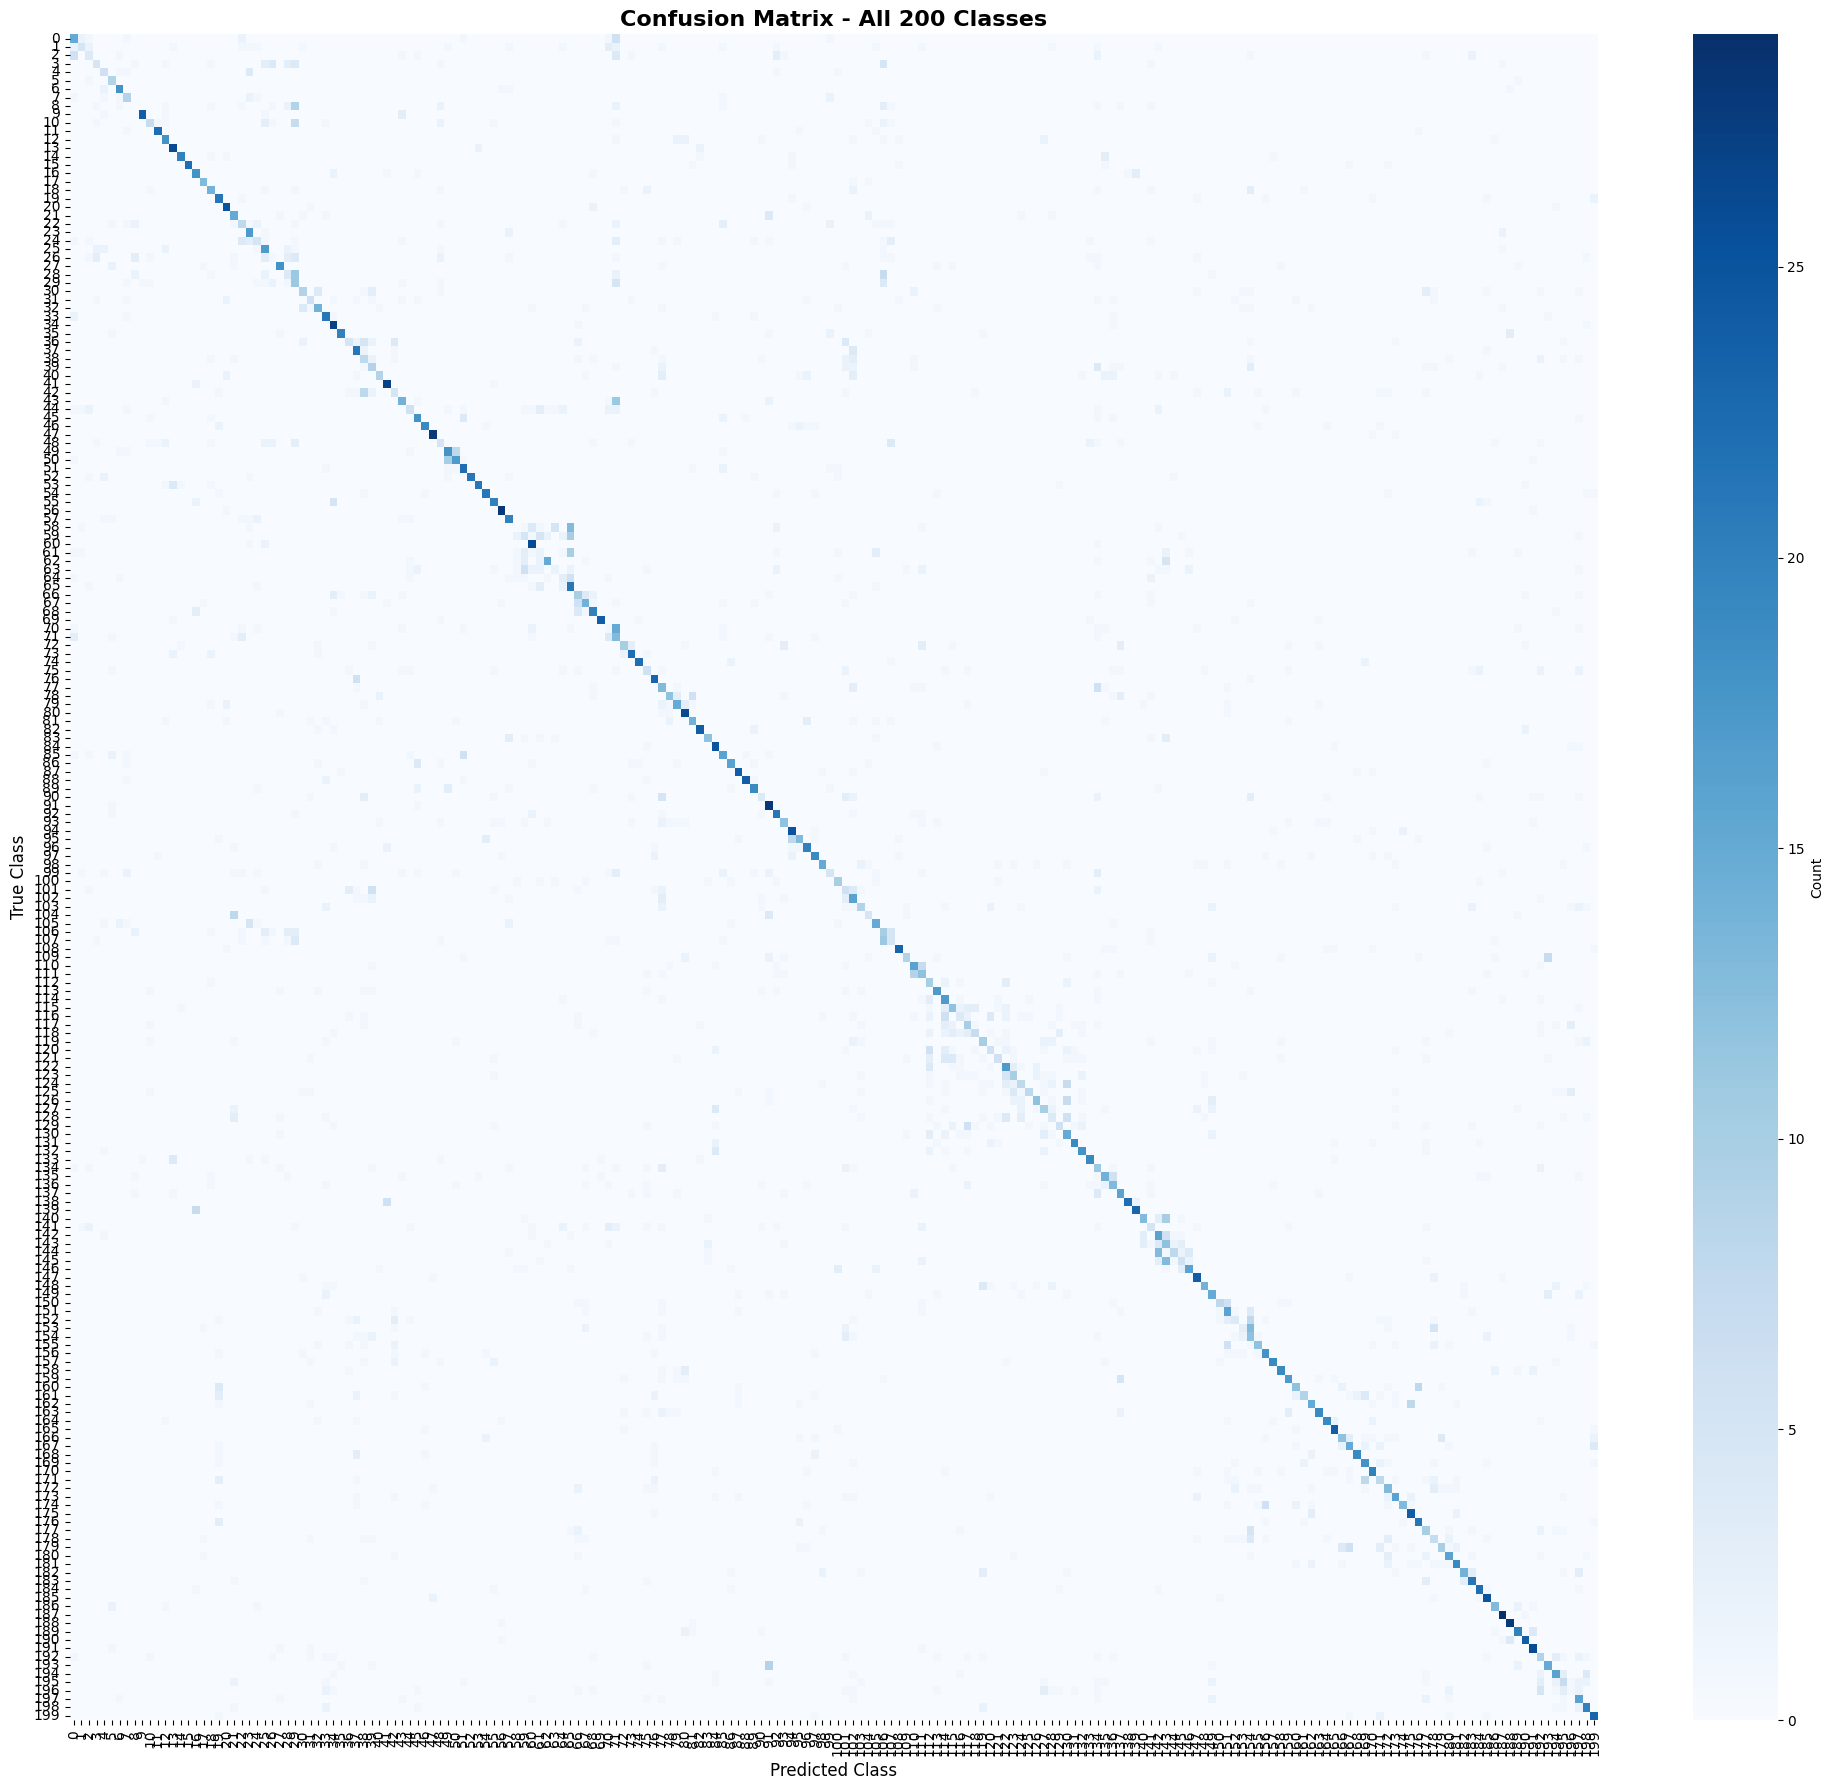

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Full confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=range(200), yticklabels=range(200),
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - All 200 Classes', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()

#### 4.8.4 Top and bottom classes by accuracy

In [ ]:
# Sort by per-class accuracy
print("TOP 10 BEST PERFORMING CLASSES")

class_accuracy = np.diag(cm) / cm.sum(axis=1)
top_10_indices = np.argsort(class_accuracy)[-10:][::-1]

for rank, idx in enumerate(top_10_indices, 1):
    print(f"{rank:2d}. Class {idx:3d}: {class_accuracy[idx]:.4f} "
          f"({int(np.diag(cm)[idx])}/{int(cm.sum(axis=1)[idx])} correct)")

print("TOP 10 WORST PERFORMING CLASSES")

bottom_10_indices = np.argsort(class_accuracy)[:10]

for rank, idx in enumerate(bottom_10_indices, 1):
    print(f"{rank:2d}. Class {idx:3d}: {class_accuracy[idx]:.4f} "
          f"({int(np.diag(cm)[idx])}/{int(cm.sum(axis=1)[idx])} correct)")

TOP 10 BEST PERFORMING CLASSES
 1. Class 187: 0.9667 (29/30 correct)
 2. Class 188: 0.9333 (28/30 correct)
 3. Class  56: 0.9333 (28/30 correct)
 4. Class  91: 0.9333 (28/30 correct)
 5. Class  47: 0.9333 (28/30 correct)
 6. Class  41: 0.9000 (27/30 correct)
 7. Class  34: 0.9000 (27/30 correct)
 8. Class 191: 0.8667 (26/30 correct)
 9. Class  60: 0.8667 (26/30 correct)
10. Class  17: 0.8667 (13/15 correct)
TOP 10 WORST PERFORMING CLASSES
 1. Class   8: 0.0000 (0/29 correct)
 2. Class  58: 0.0000 (0/30 correct)
 3. Class  26: 0.0333 (1/30 correct)
 4. Class  70: 0.0333 (1/30 correct)
 5. Class 196: 0.0333 (1/30 correct)
 6. Class  63: 0.0667 (2/30 correct)
 7. Class  61: 0.0667 (2/30 correct)
 8. Class 153: 0.1000 (3/30 correct)
 9. Class  90: 0.1333 (4/30 correct)
10. Class 128: 0.1333 (4/30 correct)


#### 4.8.5 Per class accuracy distribution

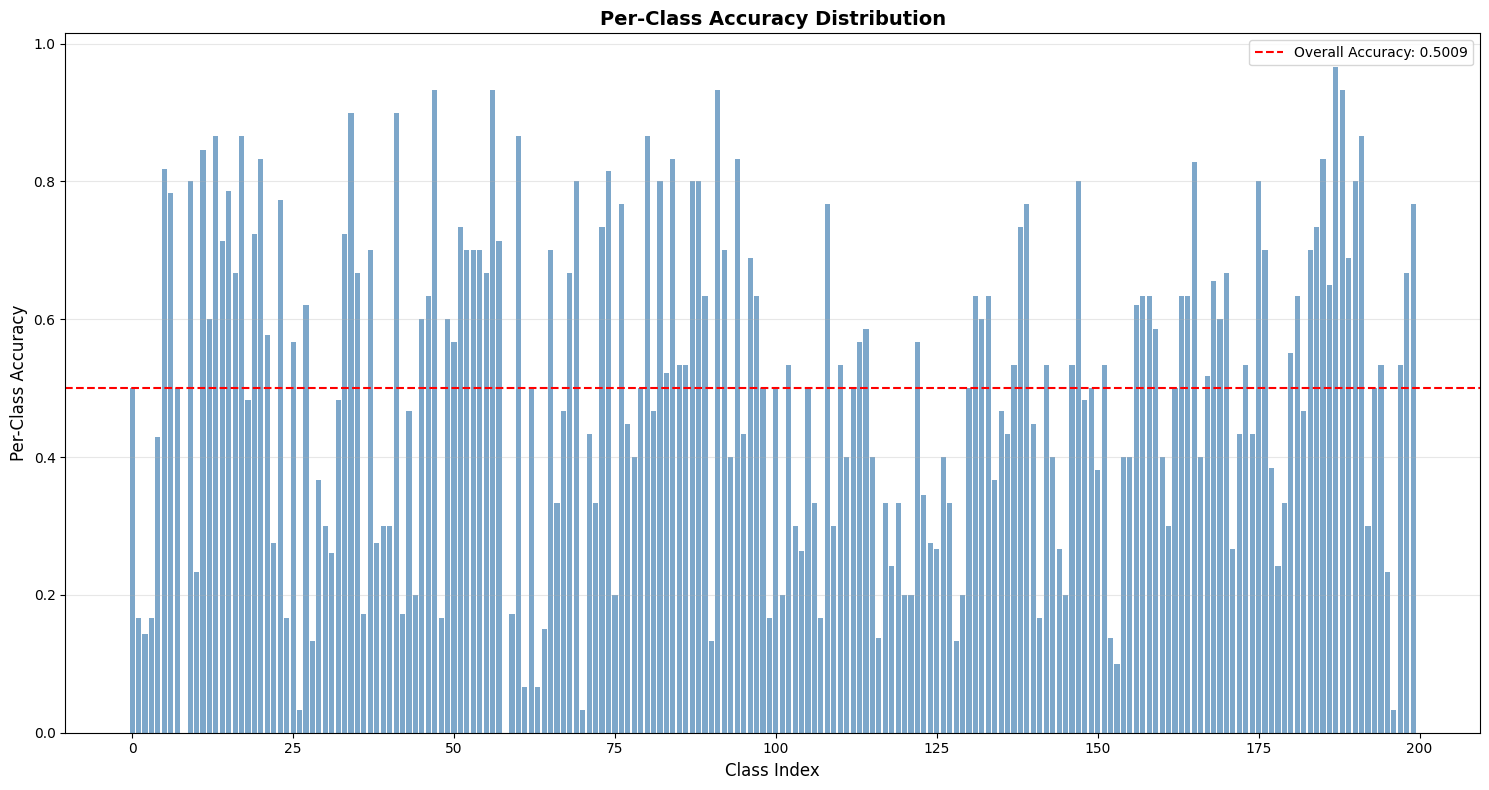

In [ ]:
plt.figure(figsize=(15, 8))
diagonal_accuracy = np.diag(cm) / cm.sum(axis=1)
plt.bar(range(200), diagonal_accuracy, color='steelblue', alpha=0.7)
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Overall Accuracy: {accuracy:.4f}')
plt.xlabel('Class Index', fontsize=12)
plt.ylabel('Per-Class Accuracy', fontsize=12)
plt.title('Per-Class Accuracy Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

#### 4.8.6 Per class Accuracy, Precision, Recall, F1-score

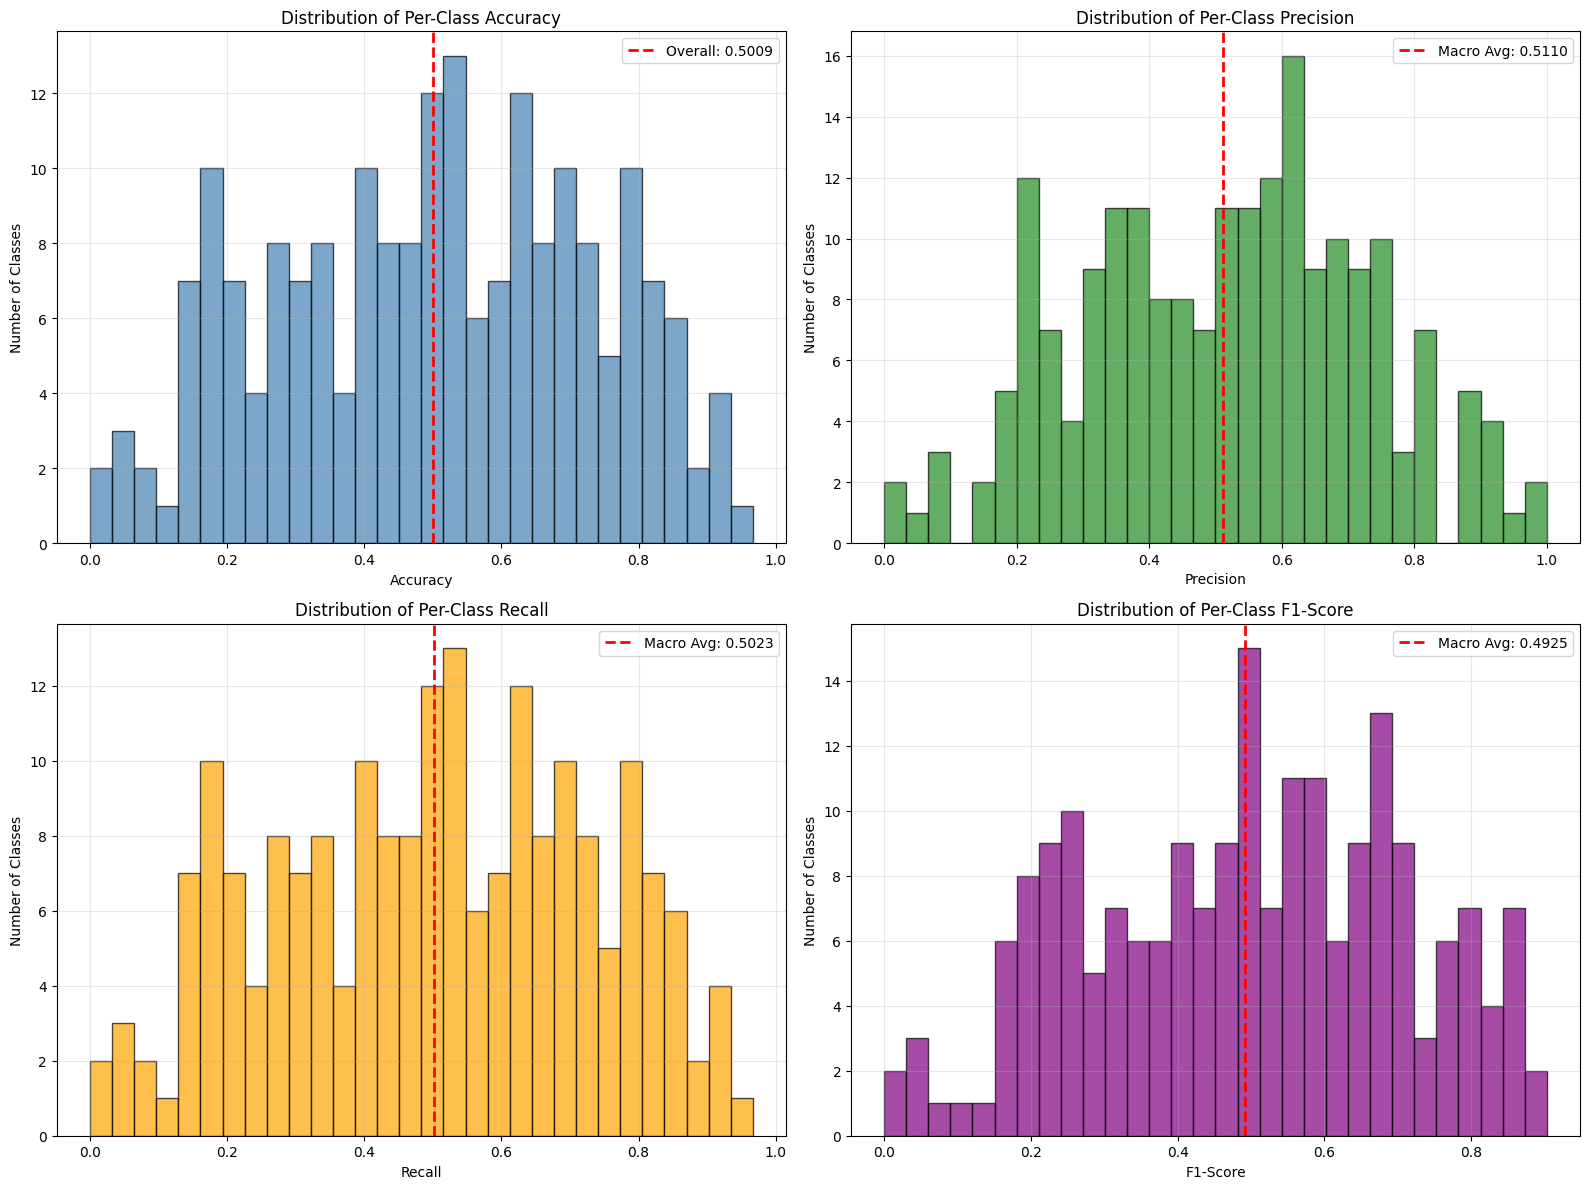

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy distribution
axes[0, 0].hist(class_accuracy, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(accuracy, color='red', linestyle='--', linewidth=2,
                   label=f'Overall: {accuracy:.4f}')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Number of Classes')
axes[0, 0].set_title('Distribution of Per-Class Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Precision distribution
axes[0, 1].hist(precision_per_class, bins=30, color='forestgreen', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(precision_macro, color='red', linestyle='--', linewidth=2,
                   label=f'Macro Avg: {precision_macro:.4f}')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_ylabel('Number of Classes')
axes[0, 1].set_title('Distribution of Per-Class Precision')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Recall distribution
axes[1, 0].hist(recall_per_class, bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(recall_macro, color='red', linestyle='--', linewidth=2,
                   label=f'Macro Avg: {recall_macro:.4f}')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Number of Classes')
axes[1, 0].set_title('Distribution of Per-Class Recall')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: F1-Score distribution
axes[1, 1].hist(f1_per_class, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(f1_macro, color='red', linestyle='--', linewidth=2,
                   label=f'Macro Avg: {f1_macro:.4f}')
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_ylabel('Number of Classes')
axes[1, 1].set_title('Distribution of Per-Class F1-Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5 Short Report

### **Data Processing**
The CUB-200-2011 dataset contains 11,788 images across 200 bird species. We used the official train/test split (5,994 train / 5,794 test) and further split the training set 90:10 into train/validation subsets using stratified sampling to preserve class distributions (~27 images per class for training).

All images were cropped to their annotated bounding boxes to remove background clutter and focus on the bird, then resized to the model's input resolution using LANCZOS interpolation. Data augmentation included horizontal flips, rotation (±36°), zoom (±15%), translation (±10%), brightness (±20%), and contrast (±20%).

### **Model 1: EfficientNetB5 (Transfer Learning)**
We used a two-phase progressive unfreezing strategy. **Phase 1** (20 epochs): the EfficientNetB5 backbone was frozen with ImageNet weights, and only the custom classification head (GAP -> BN -> Dropout(0.3) -> Dense(512) -> Dropout(0.5) -> Dense(200)) was trained using Adam (lr=1e-3) with ReduceLROnPlateau. **Phase 2** (20 epochs): blocks 6, 7, and the top convolutional layers were unfrozen while keeping all BatchNormalization layers frozen to preserve ImageNet statistics. RMSprop with cosine decay (initial lr=5e-5) was used for fine-tuning. This block-aware unfreezing strategy was chosen because earlier blocks capture general features (edges, textures) that transfer well, while later blocks need adaptation for bird-specific patterns. Keeping BN frozen prevents the small batch statistics (~32 samples) from corrupting the population statistics estimated from millions of ImageNet images.

### **Model 2: Custom CNN (From Scratch)**
A ResNet-style architecture with 7.2M parameters was designed from scratch. Key design choices: (1) **Residual connections** to enable gradient flow through 20+ layers; (2) **Pre-activation BatchNorm** (BN -> ReLU -> Conv) for more stable training; (3) **Squeeze-and-Excitation attention** to learn channel-wise feature importance (e.g., emphasise colour channels for colourful species); (4) **Depthwise separable convolutions** in Stage 4 for parameter efficiency; (5) **Global Average Pooling** instead of Flatten to reduce classifier parameters from ~5M to ~100K. Training used AdamW (weight_decay=1e-4) with warmup + cosine annealing schedule (peak lr=1e-3, 5-epoch warmup, 80 total epochs).

### **Hyperparameter Selection**
Hyperparameters were selected through systematic experimentation, isolating one variable at a time. Key findings: (1) Bounding box crops improved accuracy by 2–4% over full images; (2) Block-aware unfreezing outperformed unfreezing by arbitrary layer count; (3) Keeping BN layers frozen during fine-tuning was critical, unfreezing them degraded performance by 3-5%; (4) RMSprop outperformed Adam/AdamW for fine-tuning the pretrained model; (5) For the custom model, the augmentation-then-normalisation order was essential (augmentation on [0, 255] range, then Rescaling to [0, 1]).

### **Final Results**

| Model | Test Accuracy | Precision (macro) | Recall (macro) |
|-------|:---:|:---:|:---:|
| EfficientNetB5 (transfer) | **86%** | 86% | 86% |
| Custom CNN (from scratch) | **50%** | 51% | 50% |

## 6 Demo (Testing)

In [9]:
# Change this to the provided test folder path
DEMO_TEST_FOLDER = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Test'

# Load and prepare demo data with the same structure
demo_data = []
class_names = classes_df['class_name'].tolist()
name_to_label = {name: idx for idx, name in enumerate(class_names)}

for class_folder in sorted(os.listdir(DEMO_TEST_FOLDER)):
    class_path = os.path.join(DEMO_TEST_FOLDER, class_folder)
    if not os.path.isdir(class_path):
        continue
    label = name_to_label.get(class_folder, -1)
    if label == -1:
        continue
    for img_file in sorted(os.listdir(class_path)):
        demo_data.append({
            'full_path': os.path.join(class_path, img_file),
            'label': label
        })

demo_df = pd.DataFrame(demo_data)
print(f"Loaded {len(demo_df)} images across {demo_df['label'].nunique()} classes")

# Create demo set
def create_demo_dataset(dataframe, img_size, batch_size=32):
    def generator():
        for _, row in dataframe.iterrows():
            img = Image.open(row['full_path']).convert('RGB')
            img = img.resize((img_size, img_size), Image.LANCZOS)
            yield np.array(img, dtype=np.float32), row['label']

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

demo_data_b5 = create_demo_dataset(demo_df, img_size=456)
demo_data_cus = create_demo_dataset(demo_df, img_size=224)

Loaded 178 images across 3 classes



EfficientNetB5 (Transfer Learning)
Accuracy:  0.9382 (93.82%)
Precision: 0.9471
Recall:    0.9387
F1-Score:  0.9411


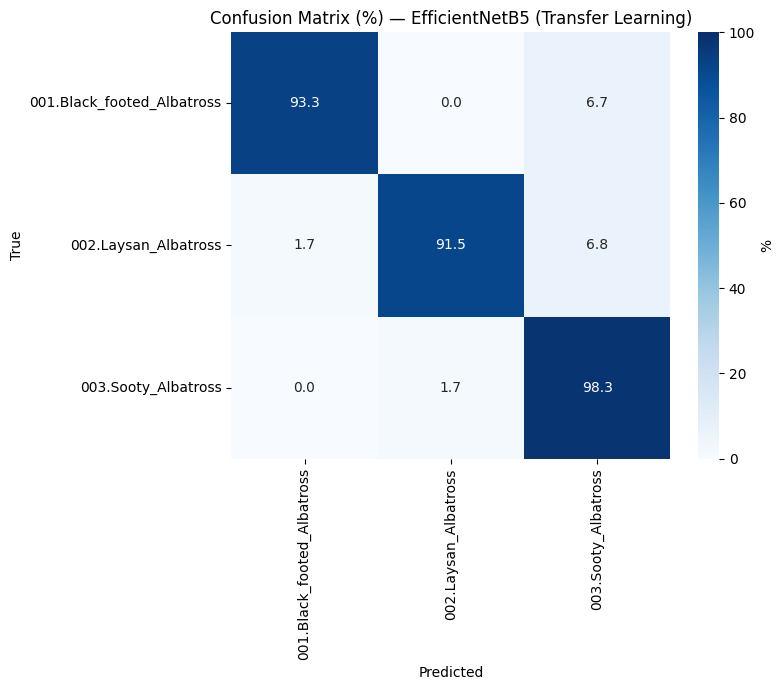

In [14]:
# Evaluate model has better performance (accuracy)
def evaluate_demo(model, dataset, model_name):
    y_true, y_pred = [], []
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(labels.numpy())
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    demo_labels = sorted(set(y_true))
    target_names = [class_names[i] for i in demo_labels]

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=demo_labels, average='macro', zero_division=0
    )

    print(f"\n{'='*50}")
    print(f"{model_name}")
    print(f"{'='*50}")
    print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {p:.4f}")
    print(f"Recall:    {r:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Uncomment this code to see confusion matrix
    # cm = confusion_matrix(y_true, y_pred, labels=demo_labels)
    # target_names = [class_names[i] for i in demo_labels]
    # n = len(demo_labels)

    # cm_pct = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # plt.figure(figsize=(max(8, n*0.15), max(7, n*0.13)))
    # sns.heatmap(cm_pct, annot=(n <= 30), fmt='.1f', cmap='Blues',
    #             xticklabels=target_names, yticklabels=target_names,
    #             vmin=0, vmax=100, cbar_kws={'label': '%'})
    # plt.title(f'Confusion Matrix (%) — {model_name}')
    # plt.xlabel('Predicted'); plt.ylabel('True')
    # plt.xticks(rotation=90, fontsize=max(4, 10 - n//20))
    # plt.yticks(rotation=0, fontsize=max(4, 10 - n//20))
    # plt.tight_layout()
    # plt.show()

    return y_true, y_pred

# Load models
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/saved_models/'
model_b5_demo = tf.keras.models.load_model(os.path.join(model_save_path, 'b5_phase2.keras'))
# model_cus_demo = tf.keras.models.load_model(os.path.join(model_save_path, 'custom_model_best.keras'))

# Run evaluation
y_true_b5, y_pred_b5 = evaluate_demo(model_b5_demo, demo_data_b5, "EfficientNetB5 (Transfer Learning)")
# y_true_cus, y_pred_cus = evaluate_demo(model_cus_demo, demo_data_cus, "Custom CNN (From Scratch)")